# Debiasing Synthetic Data Generated by Deep Generative Models

Results of the case study on the IST dataset in "Debiasing Synthetic Data Generated by Deep Generative Models", presented during the 38th Annual Conference on Neural Information Processing Systems.

In this file, the code can be extended for all categories of the outcome variable (i.e. death, dependent, not recovered, recovered). We show this by including both "death" and "dependent" in this file. In the paper, we only show the results for the outcome variable "death" since this was one of the main questions in the original IST study by Sandercock et al. (2011).

In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import product
from time import time
import os
import scipy.stats as ss
import plotnine
from plotnine import *
from mizani.formatters import percent_format 
from mizani.transforms import trans
import statsmodels.api as sm
from statsmodels.api import OLS
from utils.eval_IST import *

## Create files

In [2]:
# Presets
n_samples = [50, 160, 500, 1600, 5000] # number of observations per original data set
n_runs = 100 # number of Monte Carlo runs per number of observations
sim_dir = 'case_study_IST_data/' # output of simulations

# Original dataset
features = ['RXASP', 'OCCODE']
IST_gt = pd.read_csv(f'{sim_dir}IST_dataset_orig.csv',engine='python', usecols = features)
IST_gt = preproces_IST_aspirin(IST_gt)
# make dummies for OCCODE variable
possible_values = [1, 2, 3, 4]
dummies = pd.get_dummies(IST_gt['OCCODE'], columns=possible_values, prefix='OCCODE_dummy')
# Add dummy columns for any missing categories
for value in possible_values:
    if f'OCCODE_dummy_{value}' not in dummies.columns:
        dummies[f'OCCODE_dummy_{value}'] = 0
# Reorder columns
dummies = dummies[[f'OCCODE_dummy_{value}' for value in possible_values]]
dummies = dummies.astype('object')
IST_gt = IST_gt.join(dummies)


# calculate true proportions for outcome "death" (OCCODE_dummy_1) and "dependent" (OCCODE_dummy_2)
# in aspirin group
IST_gt_asp = IST_gt[IST_gt['RXASP'] == 'Aspirin']
gt_prop_aspirin = IST_gt_asp[['OCCODE_dummy_1', 'OCCODE_dummy_2']].mean()
# in no aspirin group
IST_gt_no_asp = IST_gt[IST_gt['RXASP'] == 'No aspirin']
gt_prop_no_aspirin = IST_gt_no_asp[['OCCODE_dummy_1', 'OCCODE_dummy_2']].mean()
# calculate risk differences
IST_gt_Risk_Differences = gt_prop_aspirin - gt_prop_no_aspirin


# calculate ground_truth
ground_truth = {'Prop_Aspirin_Death': gt_prop_aspirin[0],
                'Prop_No_Aspirin_Death': gt_prop_no_aspirin[0],
                'Prop_Aspirin_Dependent': gt_prop_aspirin[1],
                'Prop_No_Aspirin_Dependent': gt_prop_no_aspirin[1],
                'Risk_Difference_Death': IST_gt_Risk_Differences[0],
               'Risk_Difference_Dependent': IST_gt_Risk_Differences[1]}

unit_rescale = {'Prop_Aspirin_Death': np.sqrt(ground_truth['Prop_Aspirin_Death']*(1-ground_truth['Prop_Aspirin_Death'])), 
                'Prop_No_Aspirin_Death':  np.sqrt(ground_truth['Prop_No_Aspirin_Death']*(1-ground_truth['Prop_No_Aspirin_Death'])),
                'Prop_Aspirin_Dependent': np.sqrt(ground_truth['Prop_Aspirin_Dependent']*(1-ground_truth['Prop_Aspirin_Dependent'])), 
                'Prop_No_Aspirin_Dependent':  np.sqrt(ground_truth['Prop_No_Aspirin_Dependent']*(1-ground_truth['Prop_No_Aspirin_Dependent'])),
                'Risk_Difference_Death': np.sqrt((ground_truth['Prop_Aspirin_Death']*(1-ground_truth['Prop_Aspirin_Death'])) + (ground_truth['Prop_No_Aspirin_Death']*(1-ground_truth['Prop_No_Aspirin_Death']))),
               'Risk_Difference_Dependent': np.sqrt((ground_truth['Prop_Aspirin_Dependent']*(1-ground_truth['Prop_Aspirin_Dependent'])) + (ground_truth['Prop_No_Aspirin_Dependent']*(1-ground_truth['Prop_No_Aspirin_Dependent'])))}


# Load data
data = load_data(n_samples, n_runs, sim_dir)

Data is loaded and preprocessed


/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


File case_study_IST_data/IST_dataset_orig.csv not stored in 'data' object because file has aberrant directory structure
Expected files are empty here because we are not targeting OLS estimate.


In [3]:
# create dummies for original datasets and untargeted datasets
# There are already dummy variables in the targeted dataset (incorporated in the creation of targeted synthetic data)
data = create_dummiesdata(data, list_generators = ['tvae', 'custom_tvae', 'ctgan', 'custom_ctgan'])

# Create meta data
list_generators = ['tvae', 'custom_tvae', 'ctgan', 'custom_ctgan']
data = create_metadata(data, export=False, list_generators = list_generators)

# Estimate estimates
data = calculate_estimates(data, cv_folds=0, list_generators = list_generators)

# combine metadata
data = combine_metadata(data, target='meta_data', export=False)

# adapt to numeric columns
data['meta_data']['n'] = pd.to_numeric(data['meta_data']['n'], errors='coerce')
data['meta_data']['Prop_Aspirin_Death'] = pd.to_numeric(data['meta_data']['Prop_Aspirin_Death'], errors='coerce')
data['meta_data']['Prop_No_Aspirin_Death'] = pd.to_numeric(data['meta_data']['Prop_No_Aspirin_Death'], errors='coerce')
data['meta_data']['Var_Prop_Aspirin_Death'] = pd.to_numeric(data['meta_data']['Var_Prop_Aspirin_Death'], errors='coerce')
data['meta_data']['Var_Prop_No_Aspirin_Death'] = pd.to_numeric(data['meta_data']['Var_Prop_No_Aspirin_Death'], errors='coerce')
data['meta_data']['Prop_Aspirin_Dependent'] = pd.to_numeric(data['meta_data']['Prop_Aspirin_Dependent'], errors='coerce')
data['meta_data']['Prop_No_Aspirin_Dependent'] = pd.to_numeric(data['meta_data']['Prop_No_Aspirin_Dependent'], errors='coerce')
data['meta_data']['Var_Prop_Aspirin_Dependent'] = pd.to_numeric(data['meta_data']['Var_Prop_Aspirin_Dependent'], errors='coerce')
data['meta_data']['Var_Prop_No_Aspirin_Dependent'] = pd.to_numeric(data['meta_data']['Var_Prop_No_Aspirin_Dependent'], errors='coerce')

In [4]:
# were there problems somewhere?
test = data['meta_data']
rows_with_nan = test[test.isna().any(axis=1)]
rows_with_nan

,run,n,generator,Prop_Aspirin_Death,Prop_No_Aspirin_Death,Var_Prop_Aspirin_Death,Var_Prop_No_Aspirin_Death,Prop_Aspirin_Dependent,Prop_No_Aspirin_Dependent,Var_Prop_Aspirin_Dependent,Var_Prop_No_Aspirin_Dependent
ctgan_untargeted,run_34,500,ctgan_untargeted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctgan_untargeted,run_69,500,ctgan_untargeted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctgan_untargeted,run_25,5000,ctgan_untargeted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# create extra estimators
data['meta_data']['Risk_Difference_Death'] = data['meta_data']['Prop_Aspirin_Death'] - data['meta_data']['Prop_No_Aspirin_Death']
data['meta_data']['SE_Risk_Difference_Death'] = np.sqrt(data['meta_data']['Var_Prop_Aspirin_Death'] + data['meta_data']['Var_Prop_No_Aspirin_Death'])
data['meta_data']['SE_Risk_Difference_corrected_Death'] = np.sqrt(data['meta_data']['Var_Prop_Aspirin_Death'] + data['meta_data']['Var_Prop_No_Aspirin_Death'])*np.sqrt(2)
data['meta_data'].loc['Original_data', 'SE_Risk_Difference_corrected_Death'] = data['meta_data'].loc['Original_data', 'SE_Risk_Difference_Death'] # Here I say that the Raab correction factor should not be used!

data['meta_data']['Risk_Difference_Dependent'] = data['meta_data']['Prop_Aspirin_Dependent'] - data['meta_data']['Prop_No_Aspirin_Dependent']
data['meta_data']['SE_Risk_Difference_Dependent'] = np.sqrt(data['meta_data']['Var_Prop_Aspirin_Dependent'] + data['meta_data']['Var_Prop_No_Aspirin_Dependent'])
data['meta_data']['SE_Risk_Difference_corrected_Dependent'] = np.sqrt(data['meta_data']['Var_Prop_Aspirin_Dependent'] + data['meta_data']['Var_Prop_No_Aspirin_Dependent'])*np.sqrt(2)
data['meta_data'].loc['Original_data', 'SE_Risk_Difference_corrected_Dependent'] = data['meta_data'].loc['Original_data', 'SE_Risk_Difference_Dependent'] # Here I say that the Raab correction factor should not be used!

In [6]:
# Look at meta_data
meta_data = data['meta_data']
meta_data

,run,n,generator,Prop_Aspirin_Death,Prop_No_Aspirin_Death,Var_Prop_Aspirin_Death,Var_Prop_No_Aspirin_Death,Prop_Aspirin_Dependent,Prop_No_Aspirin_Dependent,Var_Prop_Aspirin_Dependent,Var_Prop_No_Aspirin_Dependent,Risk_Difference_Death,SE_Risk_Difference_Death,SE_Risk_Difference_corrected_Death,Risk_Difference_Dependent,SE_Risk_Difference_Dependent,SE_Risk_Difference_corrected_Dependent
Original_data,run_1,50,Original_data,0.178571,0.227273,0.005239,0.007983,0.464286,0.318182,0.008883,0.009861,-0.048701,0.114984,0.114984,0.146104,0.136909,0.136909
tvae_untargeted,run_1,50,tvae_untargeted,0.250000,0.269231,0.007812,0.007567,0.250000,0.230769,0.007812,0.006827,-0.019231,0.124015,0.175383,0.019231,0.120996,0.171114
custom_tvae_untargeted,run_1,50,custom_tvae_untargeted,0.142857,0.090909,0.004373,0.003757,0.500000,0.727273,0.008929,0.009016,0.051948,0.090165,0.127513,-0.227273,0.133957,0.189443
ctgan_untargeted,run_1,50,ctgan_untargeted,0.260870,0.259259,0.008383,0.007113,0.260870,0.259259,0.008383,0.007113,0.001610,0.124483,0.176046,0.001610,0.124483,0.176046
custom_ctgan_untargeted,run_1,50,custom_ctgan_untargeted,0.125000,0.115385,0.004557,0.003926,0.458333,0.384615,0.010344,0.009103,0.009615,0.092104,0.130254,0.073718,0.139455,0.197219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
custom_ctgan_untargeted,run_100,5000,custom_ctgan_untargeted,0.037654,0.150989,0.000014,0.000052,0.593341,0.297941,0.000096,0.000084,-0.113336,0.008131,0.011499,0.295400,0.013419,0.018978
tvae_targeted,run_100,5000,tvae_targeted,0.213147,0.233735,0.000084,0.000090,0.421514,0.426908,0.000122,0.000122,-0.020588,0.013168,0.018623,-0.005394,0.015628,0.022102
custom_tvae_targeted,run_100,5000,custom_tvae_targeted,0.212231,0.228989,0.000068,0.000070,0.431700,0.433781,0.000100,0.000097,-0.016758,0.011725,0.016581,-0.002081,0.014015,0.019821
ctgan_targeted,run_100,5000,ctgan_targeted,0.213147,0.233735,0.000084,0.000090,0.421514,0.426908,0.000122,0.000122,-0.020588,0.013168,0.018623,-0.005394,0.015628,0.022102


## Evaluation for outcome "Death"

### Bias

['Original_data', 'custom_ctgan_untargeted', 'custom_ctgan_targeted', 'ctgan_untargeted', 'ctgan_targeted', 'custom_tvae_untargeted', 'custom_tvae_targeted', 'tvae_untargeted', 'tvae_targeted']


/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 9 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


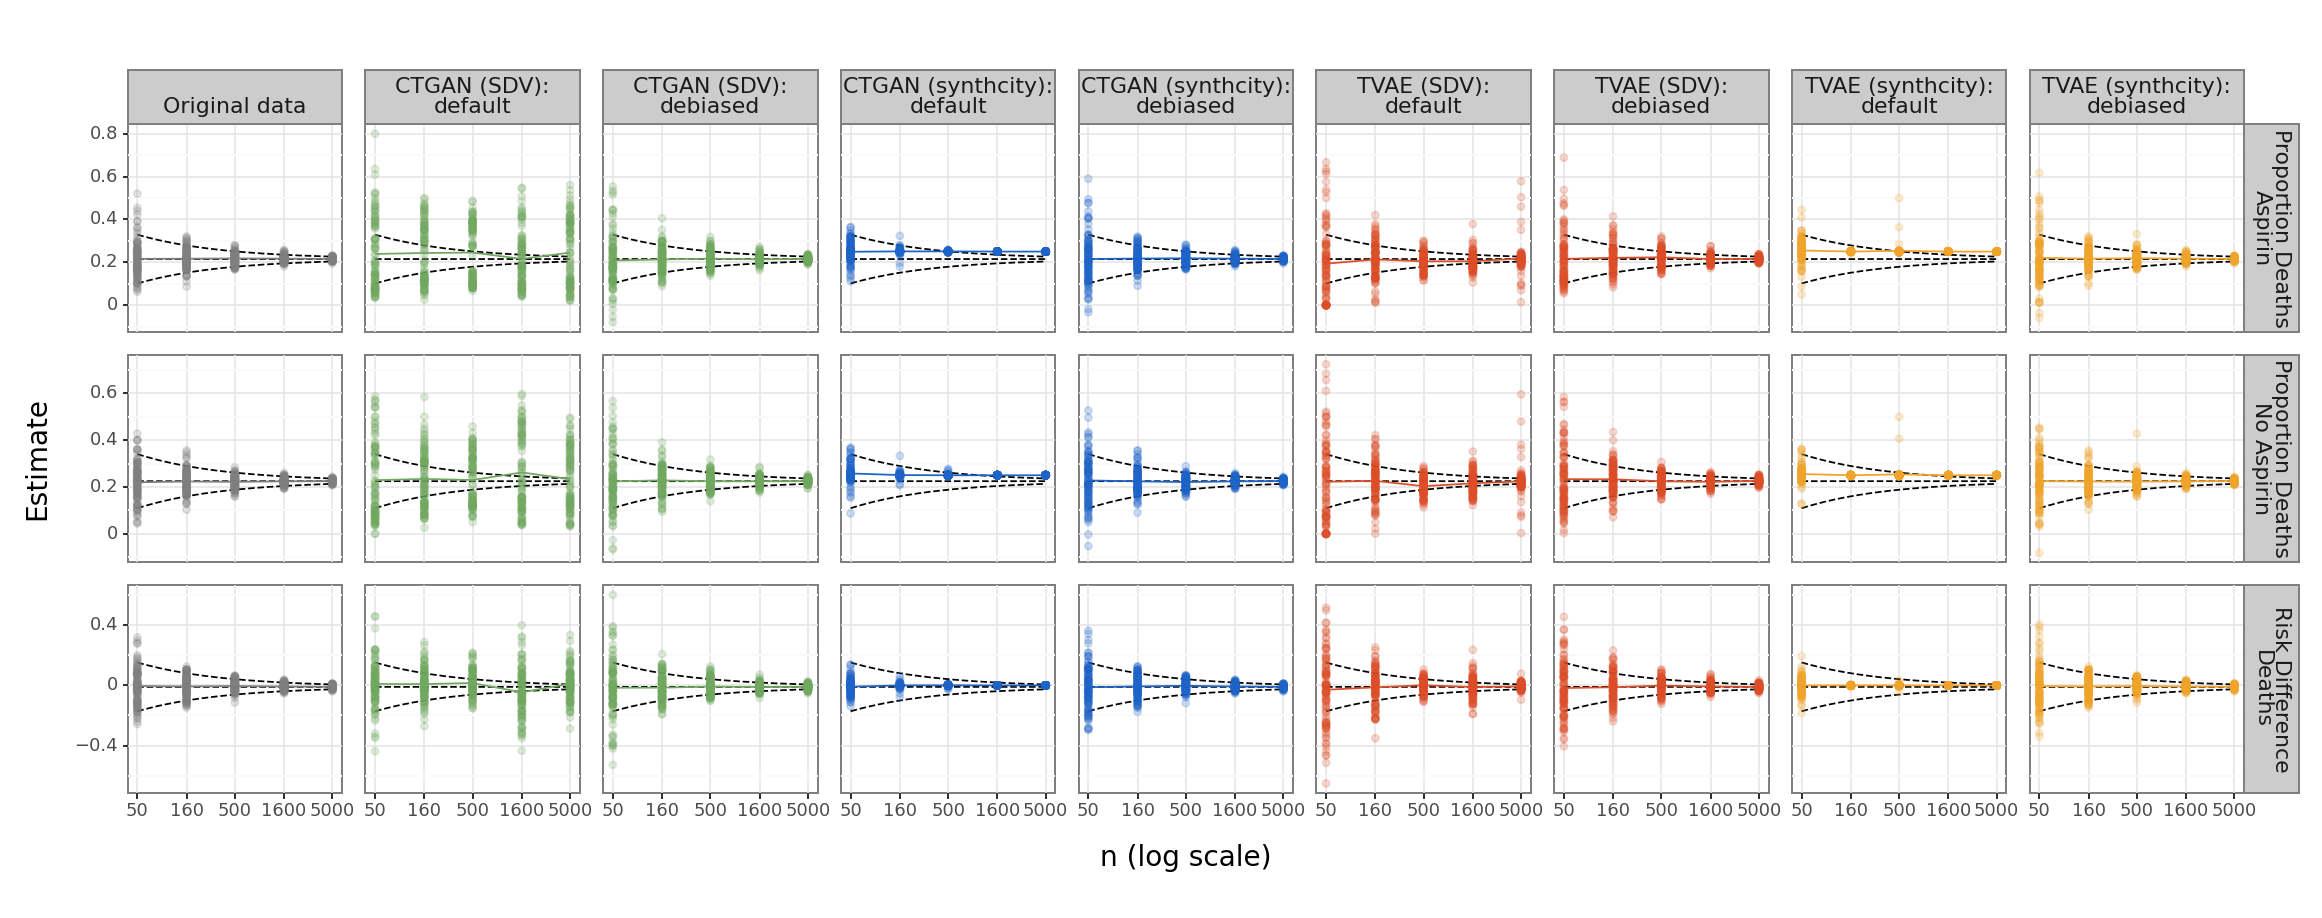

In [7]:
new_labels = {'Original_data': '\nOriginal data',
              'custom_ctgan_untargeted': 'CTGAN (SDV):\ndefault', 'ctgan_untargeted': 'CTGAN (synthcity):\ndefault',
              'custom_tvae_untargeted':'TVAE (SDV):\ndefault', 'tvae_untargeted':'TVAE (synthcity):\ndefault',
              'custom_ctgan_targeted': 'CTGAN (SDV):\ndebiased', 'ctgan_targeted': 'CTGAN (synthcity):\ndebiased',
              'custom_tvae_targeted':'TVAE (SDV):\ndebiased', 'tvae_targeted':'TVAE (synthcity):\ndebiased',
             'Prop_Aspirin_Death':'Proportion Deaths\nAspirin',
             'Prop_No_Aspirin_Death':'Proportion Deaths\nNo Aspirin',
             'Risk_Difference_Death':'Risk Difference\nDeaths'}  

plot_IST_estimates = plot_bias(data['meta_data'], 
                               select_estimators=['Prop_Aspirin_Death', 'Prop_No_Aspirin_Death', 'Risk_Difference_Death'], 
                               name_original=['Original_data'],
                               list_generators=[ 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                               plot_outliers=True,
                               unit_rescale=unit_rescale,
                               plot_estimates=True,
                               ground_truth=ground_truth,
                               labels_plot = new_labels)
print(plot_IST_estimates)

In [ ]:
# Save the figure
plot_IST_estimates.save('plot_IST_estimates.pdf', width=None, height=None, dpi=180)

### Convergence rate

Note that for ctgan_untargeted (synthcity) it was not possible to calculate the convergence rate, since the variance on the estimates was 0 for sample size 1600 and 5000.

In [8]:
select_estimators=['Prop_Aspirin_Death']
table_convergence_rate(meta_data, select_estimators, unit_rescale, show_ci=True)

/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log


,generator,estimator,convergence rate
0,Original_data,Prop_Aspirin_Death,0.54 [0.50; 0.59]
1,ctgan_targeted,Prop_Aspirin_Death,0.59 [0.52; 0.67]
2,ctgan_untargeted,Prop_Aspirin_Death,inf [nan; nan]
3,custom_ctgan_targeted,Prop_Aspirin_Death,0.54 [0.48; 0.61]
4,custom_ctgan_untargeted,Prop_Aspirin_Death,0.02 [-0.06; 0.11]
5,custom_tvae_targeted,Prop_Aspirin_Death,0.53 [0.50; 0.56]
6,custom_tvae_untargeted,Prop_Aspirin_Death,0.23 [-0.17; 0.62]
7,tvae_targeted,Prop_Aspirin_Death,0.60 [0.51; 0.70]
8,tvae_untargeted,Prop_Aspirin_Death,inf [nan; nan]


In [9]:
select_estimators=['Prop_No_Aspirin_Death']
table_convergence_rate(meta_data, select_estimators, unit_rescale, show_ci=True)

/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log


,generator,estimator,convergence rate
0,Original_data,Prop_No_Aspirin_Death,0.54 [0.52; 0.57]
1,ctgan_targeted,Prop_No_Aspirin_Death,0.58 [0.55; 0.62]
2,ctgan_untargeted,Prop_No_Aspirin_Death,inf [nan; nan]
3,custom_ctgan_targeted,Prop_No_Aspirin_Death,0.52 [0.46; 0.59]
4,custom_ctgan_untargeted,Prop_No_Aspirin_Death,0.02 [-0.15; 0.18]
5,custom_tvae_targeted,Prop_No_Aspirin_Death,0.53 [0.49; 0.58]
6,custom_tvae_untargeted,Prop_No_Aspirin_Death,0.23 [-0.14; 0.61]
7,tvae_targeted,Prop_No_Aspirin_Death,0.58 [0.49; 0.67]
8,tvae_untargeted,Prop_No_Aspirin_Death,inf [nan; nan]


In [10]:
select_estimators=['Risk_Difference_Death']
table_convergence_rate(meta_data, select_estimators, unit_rescale, show_ci=True)

/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log


,generator,estimator,convergence rate
0,Original_data,Risk_Difference_Death,0.54 [0.51; 0.56]
1,ctgan_targeted,Risk_Difference_Death,0.57 [0.53; 0.60]
2,ctgan_untargeted,Risk_Difference_Death,inf [nan; nan]
3,custom_ctgan_targeted,Risk_Difference_Death,0.55 [0.48; 0.62]
4,custom_ctgan_untargeted,Risk_Difference_Death,0.01 [-0.24; 0.26]
5,custom_tvae_targeted,Risk_Difference_Death,0.53 [0.50; 0.57]
6,custom_tvae_untargeted,Risk_Difference_Death,0.46 [0.14; 0.78]
7,tvae_targeted,Risk_Difference_Death,0.57 [0.53; 0.61]
8,tvae_untargeted,Risk_Difference_Death,inf [nan; nan]


### Additional to show why NaN values for untargated synthcity generator ('ctgan_untargeted', 'tvae_untargeted')

In [11]:
select_estimators=['Prop_Aspirin_Death']
table_convergence_rate_additional(meta_data, select_estimators, unit_rescale, show_ci=True) # but now only for generators: ['ctgan_untargeted', 'tvae_untargeted']

      n      bias
0    50  0.049749
1   160  0.013239
2   500  0.002079
3  1600  0.000000
4  5000  0.000000
      n      bias
0    50  0.056331
1   160  0.001473
2   500  0.027623
3  1600  0.000000
4  5000  0.000000


/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log


,generator,estimator,convergence rate
0,ctgan_untargeted,Prop_Aspirin_Death,inf [nan; nan]
1,tvae_untargeted,Prop_Aspirin_Death,inf [nan; nan]


Based on this output, one can see that there is no variability in the estimates for sample size n=1600 and n=5000, explaining why a convergence rate based on OLS could not be estimated.

### Coverage and type 1 error rate

In [12]:
# Remember
        # calculate true proportions
        # in aspirin group
        # IST_gt_asp = IST_gt[IST_gt['RXASP'] == 'Aspirin']
        # gt_prop_aspirin = IST_gt_asp[['OCCODE_dummy_1', 'OCCODE_dummy_2']].mean()
        # in no aspirin group
        # IST_gt_no_asp = IST_gt[IST_gt['RXASP'] == 'No aspirin']
        # gt_prop_no_aspirin = IST_gt_no_asp[['OCCODE_dummy_1', 'OCCODE_dummy_2']].mean()
        # calculate risk differences
        # IST_gt_Risk_Differences = gt_prop_aspirin - gt_prop_no_aspirin

ground_truth = {'Prop_Aspirin_Death': gt_prop_aspirin[0],
                'Prop_No_Aspirin_Death': gt_prop_no_aspirin[0],
                'Prop_Aspirin_Dependent': gt_prop_aspirin[1],
                'Prop_No_Aspirin_Dependent': gt_prop_no_aspirin[1],
                'Risk_Difference_Death': IST_gt_Risk_Differences[0],
               'Risk_Difference_Dependent': IST_gt_Risk_Differences[1]}
print(ground_truth)

{'Prop_Aspirin_Death': 0.2150638032990974, 'Prop_No_Aspirin_Death': 0.22475637569977192, 'Prop_Aspirin_Dependent': 0.4074074074074074, 'Prop_No_Aspirin_Dependent': 0.41022185361808006, 'Risk_Difference_Death': -0.009692572400674504, 'Risk_Difference_Dependent': -0.002814446210672672}


#### Coverage of proportion of death in Aspirin group

In [15]:
#### Needed parameters
##
# Calculate the upper and lower bounds of the confidence interval
q = ss.norm.ppf(0.975)
upper_bound = meta_data['Prop_Aspirin_Death'] + q * np.sqrt(meta_data['Var_Prop_Aspirin_Death'])
lower_bound = meta_data['Prop_Aspirin_Death'] - q * np.sqrt(meta_data['Var_Prop_Aspirin_Death'])

# Check if the ground truth falls within the confidence interval for each row
meta_data['Prop_Aspirin_Coverage_Death'] = (
    (lower_bound <= ground_truth['Prop_Aspirin_Death']) &
    (ground_truth['Prop_Aspirin_Death'] <= upper_bound)
)

# Convert boolean values to True/False
meta_data['Prop_Aspirin_Coverage_Death'] = meta_data['Prop_Aspirin_Coverage_Death'].astype(bool)
meta_data['Prop_Aspirin_type1_Death'] = ~meta_data['Prop_Aspirin_Coverage_Death']
meta_data['Prop_Aspirin_type1_Death'] = meta_data['Prop_Aspirin_type1_Death'].astype(bool)

##
# Calculate the upper and lower bounds of the confidence interval with correction factor
upper_bound = meta_data['Prop_Aspirin_Death'] + q * np.sqrt(meta_data['Var_Prop_Aspirin_Death']) * np.sqrt(2)
lower_bound = meta_data['Prop_Aspirin_Death'] - q * np.sqrt(meta_data['Var_Prop_Aspirin_Death']) * np.sqrt(2)

# Check if the ground truth falls within the confidence interval for each row
meta_data['Prop_Aspirin_Coverage_corrected_Death'] = (
    (lower_bound <= ground_truth['Prop_Aspirin_Death']) &
    (ground_truth['Prop_Aspirin_Death'] <= upper_bound)
)

# Convert boolean values to True/False
meta_data['Prop_Aspirin_Coverage_corrected_Death'] = meta_data['Prop_Aspirin_Coverage_corrected_Death'].astype(bool)
meta_data['Prop_Aspirin_type1_corrected_Death'] = ~meta_data['Prop_Aspirin_Coverage_corrected_Death']
# Convert boolean values to True/False
meta_data['Prop_Aspirin_type1_corrected_Death'] = meta_data['Prop_Aspirin_type1_corrected_Death'].astype(bool)


##
# Important: the correction factor should not be used when looking at original data!
# So adapt the output manually to ensure this.
# Convert boolean values to True/False
meta_data.loc['Original_data', 'Prop_Aspirin_Coverage_corrected_Death'] = meta_data.loc['Original_data','Prop_Aspirin_Coverage_Death']
# meta_data['Risk_Difference_TypeI'] = not meta_data['Risk_Difference_Coverage'].astype(bool)
meta_data.loc['Original_data', 'Prop_Aspirin_type1_corrected_Death'] = ~meta_data.loc['Original_data','Prop_Aspirin_Coverage_Death']
# Convert boolean values to True/False
meta_data.loc['Original_data','Prop_Aspirin_type1_corrected_Death'] = meta_data.loc['Original_data','Prop_Aspirin_type1_corrected_Death']


/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt


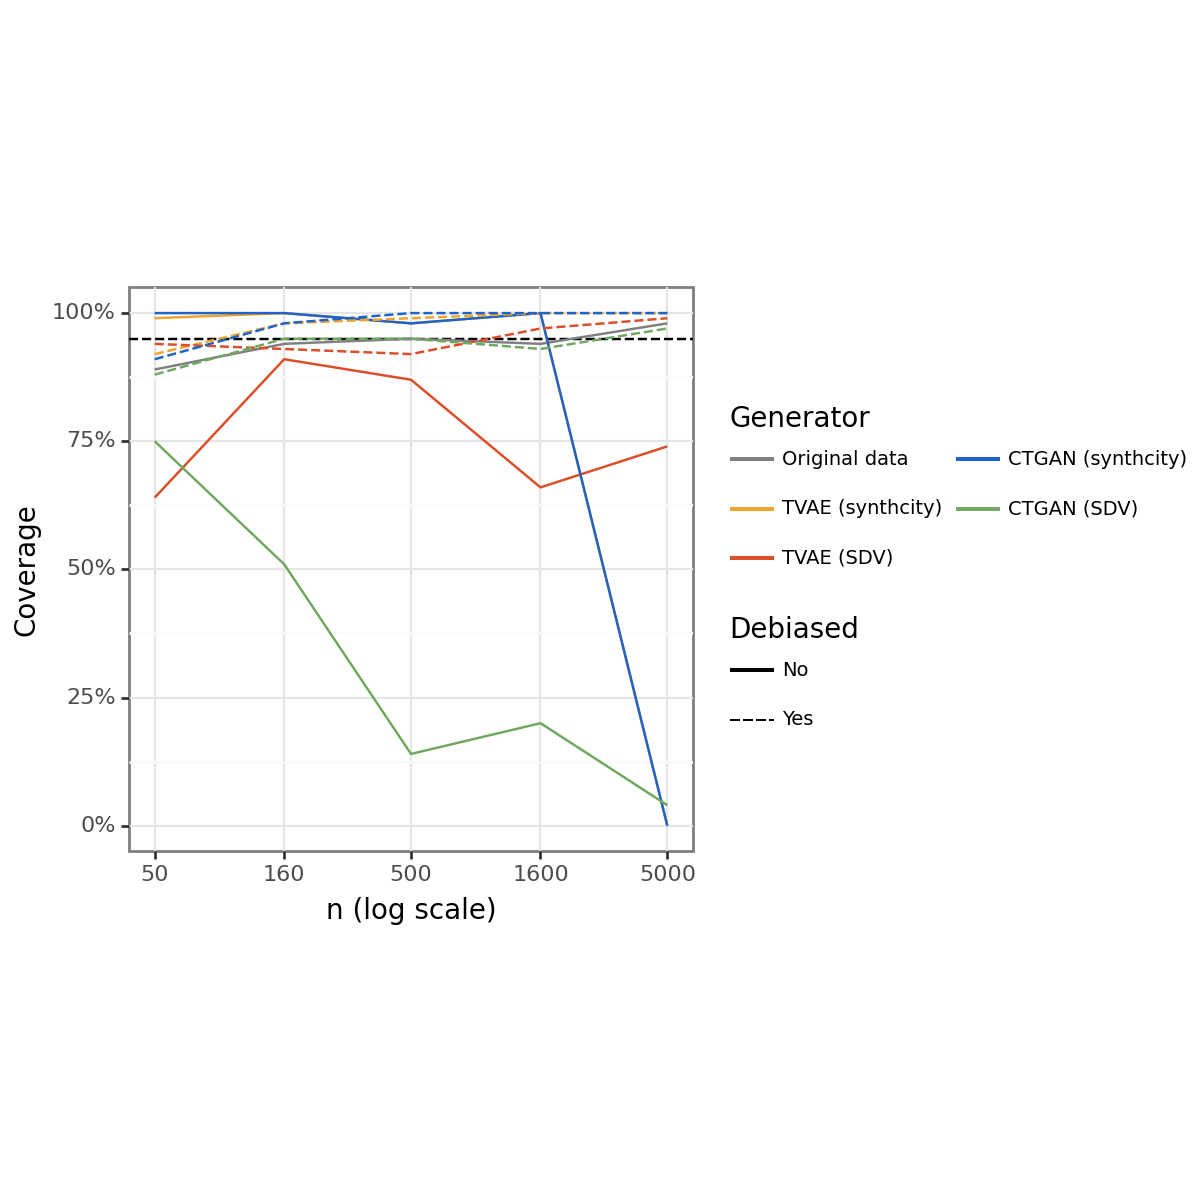

<Figure Size: (600 x 600)>

In [16]:
# Select estimators
new_labels = {'Original_data': 'Original data', 
              'custom_ctgan': 'CTGAN (SDV)', 'ctgan': 'CTGAN (synthcity)',
              'custom_tvae':'TVAE (SDV)', 'tvae':'TVAE (synthcity)'}    

select_estimators = ['Prop_Aspirin_Coverage_Death', 'Prop_Aspirin_Coverage_corrected_Death']
Coverage_death_aspirin_paper = plot_coverage_paper(meta_data, select_estimators,
                                                   name_original=['Original_data'],
                                                   list_generators=['tvae', 'custom_tvae', 'ctgan', 'custom_ctgan'],
                                                   labels_plot=new_labels,
                                                  figure_size=(6,6))
Coverage_death_aspirin_paper

In [ ]:
# Save the figure
Coverage_death_aspirin_paper.save('Coverage_death_aspirin_paper.pdf', width=None, height=None, dpi=180)

#### Type 1 error rate for risk difference

In [17]:
# First make needed variables to be able to calculate the type 1 error rate for the risk difference in outcome "death" 
data['meta_data']['n'] = pd.to_numeric(data['meta_data']['n'], errors='coerce')
data['meta_data']['Prop_Aspirin_Death'] = pd.to_numeric(data['meta_data']['Prop_Aspirin_Death'], errors='coerce')
data['meta_data']['Prop_No_Aspirin_Death'] = pd.to_numeric(data['meta_data']['Prop_No_Aspirin_Death'], errors='coerce')
data['meta_data']['Var_Prop_Aspirin_Death'] = pd.to_numeric(data['meta_data']['Var_Prop_Aspirin_Death'], errors='coerce')
data['meta_data']['Var_Prop_No_Aspirin_Death'] = pd.to_numeric(data['meta_data']['Var_Prop_No_Aspirin_Death'], errors='coerce')

# create extra estimators
data['meta_data']['Risk_Difference_Death'] = data['meta_data']['Prop_Aspirin_Death'] - data['meta_data']['Prop_No_Aspirin_Death']
data['meta_data']['SE_Risk_Difference_Death'] = np.sqrt(data['meta_data']['Var_Prop_Aspirin_Death'] + data['meta_data']['Var_Prop_No_Aspirin_Death'])
data['meta_data']['SE_Risk_Difference_corrected_Death'] = np.sqrt(data['meta_data']['Var_Prop_Aspirin_Death'] + data['meta_data']['Var_Prop_No_Aspirin_Death'])*np.sqrt(2)
data['meta_data'].loc['Original_data', 'SE_Risk_Difference_corrected_Death'] = data['meta_data'].loc['Original_data', 'SE_Risk_Difference_Death']
# Here I make sure that there is no Raab correction factor applied on the original dataset

In [18]:
#### Calculate coverage and type 1 error rate for the risk difference in outcome "death" 
##
# Calculate the upper and lower bounds of the confidence interval
q = ss.norm.ppf(0.975)
upper_bound = meta_data['Risk_Difference_Death'] + q * meta_data['SE_Risk_Difference_Death']
lower_bound = meta_data['Risk_Difference_Death'] - q * meta_data['SE_Risk_Difference_Death']

# Check if the ground truth falls within the confidence interval for each row
meta_data['Risk_Difference_Coverage_Death'] = (
    (lower_bound <= ground_truth['Risk_Difference_Death']) &
    (ground_truth['Risk_Difference_Death'] <= upper_bound)
)

# Convert boolean values to True/False
meta_data['Risk_Difference_Coverage_Death'] = meta_data['Risk_Difference_Coverage_Death'].astype(bool)
# meta_data['Risk_Difference_TypeI'] = not meta_data['Risk_Difference_Coverage'].astype(bool)
meta_data['Risk_Difference_type1_Death'] = ~meta_data['Risk_Difference_Coverage_Death']
# Convert boolean values to True/False
meta_data['Risk_Difference_type1_Death'] = meta_data['Risk_Difference_type1_Death'].astype(bool)

##
# With correction factor
upper_bound = meta_data['Risk_Difference_Death'] + q * meta_data['SE_Risk_Difference_corrected_Death']
lower_bound = meta_data['Risk_Difference_Death'] - q * meta_data['SE_Risk_Difference_corrected_Death']

# Check if the ground truth falls within the confidence interval for each row
meta_data['Risk_Difference_Coverage_corrected_Death'] = (
    (lower_bound <= ground_truth['Risk_Difference_Death']) &
    (ground_truth['Risk_Difference_Death'] <= upper_bound)
)

# Convert boolean values to True/False
meta_data['Risk_Difference_Coverage_corrected_Death'] = meta_data['Risk_Difference_Coverage_corrected_Death'].astype(bool)
# meta_data['Risk_Difference_TypeI'] = not meta_data['Risk_Difference_Coverage'].astype(bool)
meta_data['Risk_Difference_type1_corrected_Death'] = ~meta_data['Risk_Difference_Coverage_corrected_Death']
# Convert boolean values to True/False
meta_data['Risk_Difference_type1_corrected_Death'] = meta_data['Risk_Difference_type1_corrected_Death'].astype(bool)


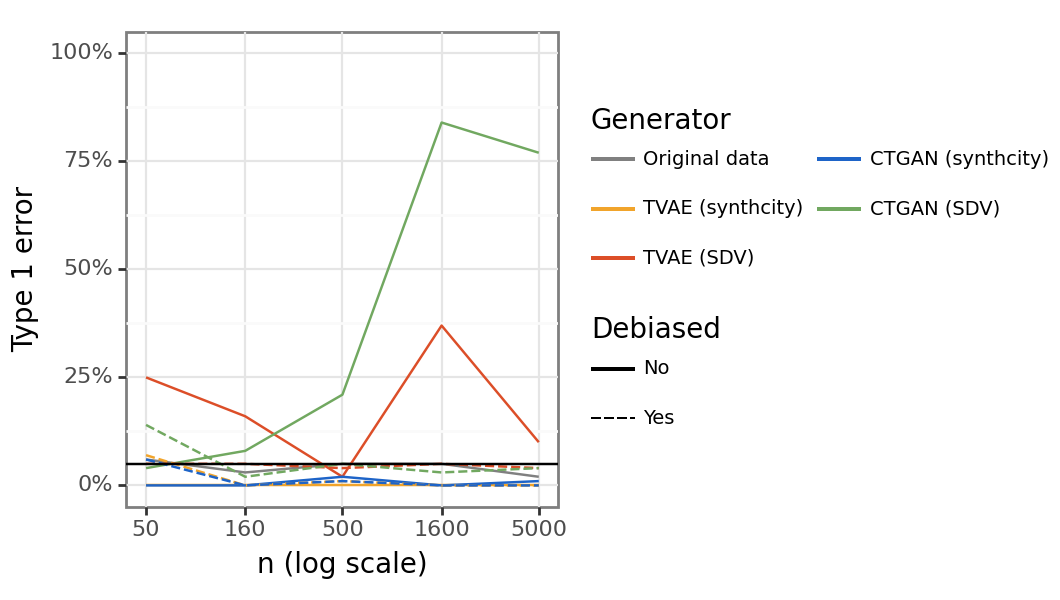

<Figure Size: (530 x 300)>

In [19]:
new_labels = {'Original_data': 'Original data', 
              'custom_ctgan': 'CTGAN (SDV)', 'ctgan': 'CTGAN (synthcity)',
              'custom_tvae':'TVAE (SDV)', 'tvae':'TVAE (synthcity)'}    
select_estimators = ['Risk_Difference_type1_Death', 'Risk_Difference_type1_corrected_Death']
RD_Type1 = plot_type_I_paper(meta_data, select_estimators, 
                             name_original=['Original_data'],
                             list_generators=['tvae', 'custom_tvae', 'ctgan', 'custom_ctgan'],
                             labels_plot=new_labels,
                            figure_size=(5.3,3))
RD_Type1

In [ ]:
# Save the figure
RD_Type1.save('RD_Type1.pdf', width=None, height=None, dpi=180)

#### 15 CIs

In [20]:
ground_truth = {'Prop_Aspirin_Death': gt_prop_aspirin[0],
                'Prop_No_Aspirin_Death': gt_prop_no_aspirin[0],
                'Prop_Aspirin_Dependent': gt_prop_aspirin[1],
                'Prop_No_Aspirin_Dependent': gt_prop_no_aspirin[1],
                'Risk_Difference_Death': IST_gt_Risk_Differences[0],
               'Risk_Difference_Dependent': IST_gt_Risk_Differences[1]}
print(ground_truth)
meta_data = data['meta_data']
meta_data_subset = meta_data[meta_data['n'] == 500]
meta_data_subset = meta_data_subset[meta_data_subset['generator'].isin(['Original_data', 'custom_ctgan_untargeted', 'custom_ctgan_targeted'])]
meta_data_subset

{'Prop_Aspirin_Death': 0.2150638032990974, 'Prop_No_Aspirin_Death': 0.22475637569977192, 'Prop_Aspirin_Dependent': 0.4074074074074074, 'Prop_No_Aspirin_Dependent': 0.41022185361808006, 'Risk_Difference_Death': -0.009692572400674504, 'Risk_Difference_Dependent': -0.002814446210672672}


,run,n,generator,Prop_Aspirin_Death,Prop_No_Aspirin_Death,Var_Prop_Aspirin_Death,Var_Prop_No_Aspirin_Death,Prop_Aspirin_Dependent,Prop_No_Aspirin_Dependent,Var_Prop_Aspirin_Dependent,...,SE_Risk_Difference_Dependent,SE_Risk_Difference_corrected_Dependent,Prop_Aspirin_Coverage_Death,Prop_Aspirin_type1_Death,Prop_Aspirin_Coverage_corrected_Death,Prop_Aspirin_type1_corrected_Death,Risk_Difference_Coverage_Death,Risk_Difference_type1_Death,Risk_Difference_Coverage_corrected_Death,Risk_Difference_type1_corrected_Death
Original_data,run_1,500,Original_data,0.195021,0.250965,0.000651,0.000726,0.468880,0.389961,0.001033,...,0.044179,0.044179,True,False,True,False,True,False,True,False
custom_ctgan_untargeted,run_1,500,custom_ctgan_untargeted,0.092511,0.128205,0.000370,0.000409,0.502203,0.380952,0.001101,...,0.044330,0.062692,False,True,False,True,True,False,True,False
custom_ctgan_targeted,run_1,500,custom_ctgan_targeted,0.164389,0.244025,0.000605,0.000676,0.469039,0.386913,0.001097,...,0.044340,0.062706,False,True,True,False,True,False,True,False
Original_data,run_2,500,Original_data,0.195489,0.209402,0.000591,0.000707,0.492481,0.393162,0.000940,...,0.044263,0.044263,True,False,True,False,True,False,True,False
custom_ctgan_untargeted,run_2,500,custom_ctgan_untargeted,0.098039,0.138776,0.000347,0.000488,0.474510,0.497959,0.000978,...,0.044702,0.063218,False,True,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
custom_ctgan_untargeted,run_99,500,custom_ctgan_untargeted,0.273859,0.409266,0.000825,0.000933,0.543568,0.413127,0.001029,...,0.044335,0.062699,False,True,True,False,False,True,False,True
custom_ctgan_targeted,run_99,500,custom_ctgan_targeted,0.191353,0.239835,0.000642,0.000704,0.482561,0.451741,0.001036,...,0.044636,0.063124,True,False,True,False,True,False,True,False
Original_data,run_100,500,Original_data,0.225000,0.259091,0.000623,0.000873,0.392857,0.490909,0.000852,...,0.044585,0.044585,True,False,True,False,True,False,True,False
custom_ctgan_untargeted,run_100,500,custom_ctgan_untargeted,0.082192,0.177885,0.000258,0.000703,0.455479,0.370192,0.000849,...,0.044388,0.062774,False,True,False,True,False,True,False,True


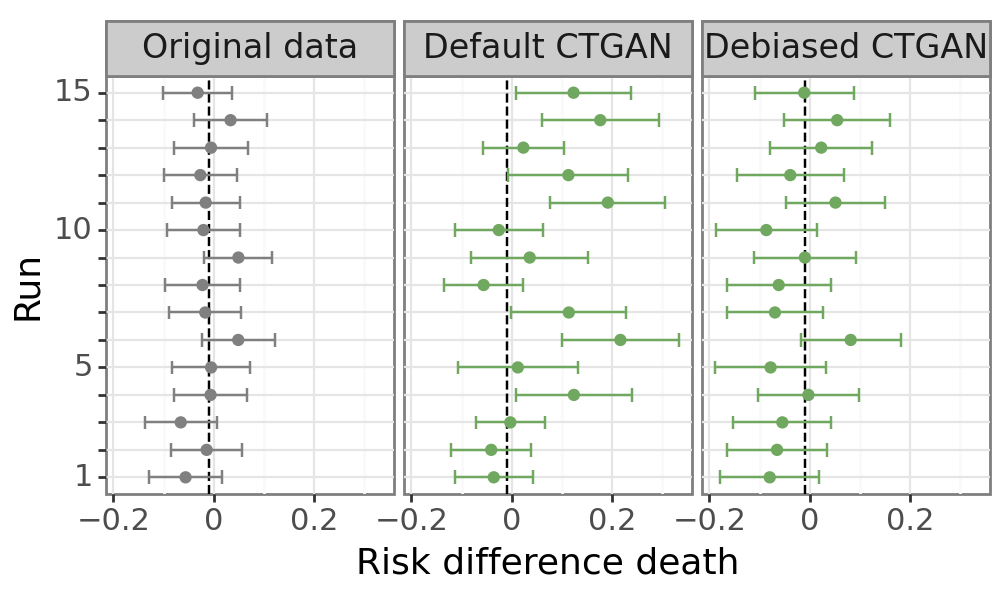

<Figure Size: (500 x 300)>

In [21]:
### Make figure that compares the first 15 confidence intervals
# Presets
n_runs = 15 # plot first 15 runs
select_estimator = 'Risk_Difference_Death' 
select_estimator_ylab = 'Risk difference death'
q = ss.norm.ppf(0.975)

# Reformating 
plot_data = meta_data_subset.head(n=n_runs*3).copy() # select first n_runs

plot_data['run'] =  pd.Categorical(list(map(lambda x: str(int(x[len('run_'):])), plot_data['run'])), # change label 
                                   categories=[str(i) for i in range(n_runs+1)]) # reorder categories

# Add correction factor
plot_data = pd.concat([plot_data.assign(correction_factor = 1, formula_SE='Naive SE'),
                       plot_data.assign(correction_factor = np.sqrt(2), formula_SE='Model-based SE')], axis=0)
plot_data['formula_SE'] =  pd.Categorical(plot_data['formula_SE'], categories=['Naive SE', 'Model-based SE']) # reorder categories

# Calculate confidence intervals
plot_data[select_estimator + '_ll'] = plot_data.apply(lambda i: i[select_estimator] - i['correction_factor']*q*i['SE_Risk_Difference_Death'], axis=1) # lower limit of CI
plot_data[select_estimator + '_ul'] = plot_data.apply(lambda i: i[select_estimator] + i['correction_factor']*q*i['SE_Risk_Difference_Death'], axis=1) # upper limit of CI

# Relabel
relabel_generators = {'Original_data': 'Original data', 
                      'custom_ctgan_untargeted': 'Default CTGAN',
                      'custom_ctgan_targeted': 'Debiased CTGAN'}
# Reorder levels of 'generator' variable
plot_data['generator'] = pd.Categorical(plot_data['generator'], categories=[ 'Original_data', 'custom_ctgan_untargeted', 'custom_ctgan_targeted'])

# I only want to display the confidence intervals with correction factor Raab. 
# However, this should not be applied on original data, so therefore
# I first take the confidence intervals of the uncorrected and copy paste them in corrected confidence intervals for original data
plot_data.loc[(plot_data['formula_SE'] == 'Model-based SE') & (plot_data.index == 'Original_data'), select_estimator + '_ll'] = plot_data.loc[(plot_data['formula_SE'] == 'Naive SE') & (plot_data.index == 'Original_data'), select_estimator + '_ll']
plot_data.loc[(plot_data['formula_SE'] == 'Model-based SE') & (plot_data.index == 'Original_data'), select_estimator + '_ul'] = plot_data.loc[(plot_data['formula_SE'] == 'Naive SE') & (plot_data.index == 'Original_data'), select_estimator + '_ul']
plot_data_Raab = plot_data[plot_data['formula_SE'] == 'Model-based SE']

# Add ground truth to each facet
intercepts = pd.DataFrame({'generator': plot_data['generator'].unique(),
                           'estimator': [select_estimator]*len(plot_data['generator'].unique()),
                           'intercept': [ground_truth[select_estimator]]*len(plot_data['generator'].unique())})

plot_CI_corrected_paper = ggplot(plot_data_Raab.query('not (generator==\'original\' & formula_SE==\'Corrected SE\')'), 
                                 aes(y=select_estimator, x='run', colour='generator', group='formula_SE', alpha='formula_SE')) +\
    geom_hline(data=intercepts, mapping=aes(yintercept='intercept', linetype='generator'), colour='black') +\
    geom_point(position=position_dodge(0.75)) +\
    scale_colour_manual(values={'Original_data': '#808080', 'custom_ctgan_untargeted': '#71A860', 'custom_ctgan_targeted': '#71A860'}) +\
    scale_linetype_manual(values={'Original_data': 'dashed', 'custom_ctgan_untargeted': 'dashed', 'custom_ctgan_targeted': 'dashed'}, breaks=['original'], labels=['Population parameter']) +\
    scale_alpha_manual(values={'Naive SE': 1, 'Model-based SE': 1}) +\
    geom_errorbar(aes(ymin=select_estimator + '_ll', ymax=select_estimator + '_ul', group='formula_SE'), position = position_dodge(0.75)) +\
    facet_wrap('generator', labeller=labeller(cols=lambda x: relabel_generators[x])) +\
    labs(y=select_estimator_ylab, x='Run') +\
    guides(alpha=guide_legend(title='', reverse=True), 
           colour=False,
           linetype=guide_legend(title='')) +\
    scale_x_discrete(breaks=[str(i) for i in range(1, 16)], labels=['1','','','','5','','','','','10','','','','','15']) +\
    theme_bw() +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=13), # axis title size
          strip_text=element_text(size=12), # facet_grid title size
          axis_text=element_text(size=11), # axis labels size
          legend_position='none',
          legend_title=element_blank(),
          legend_text=element_text(size=10),
          figure_size=(5,3)) +\
    coord_flip()
plot_CI_corrected_paper


In [ ]:
# Save the figure
plot_CI_corrected_paper.save('plot_CI_corrected_paper.pdf', width=None, height=None, dpi=180)

## Evaluation for outcome "Dependent"

### Bias

['Original_data', 'custom_ctgan_untargeted', 'custom_ctgan_targeted', 'ctgan_untargeted', 'ctgan_targeted', 'custom_tvae_untargeted', 'custom_tvae_targeted', 'tvae_untargeted', 'tvae_targeted']


/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 9 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


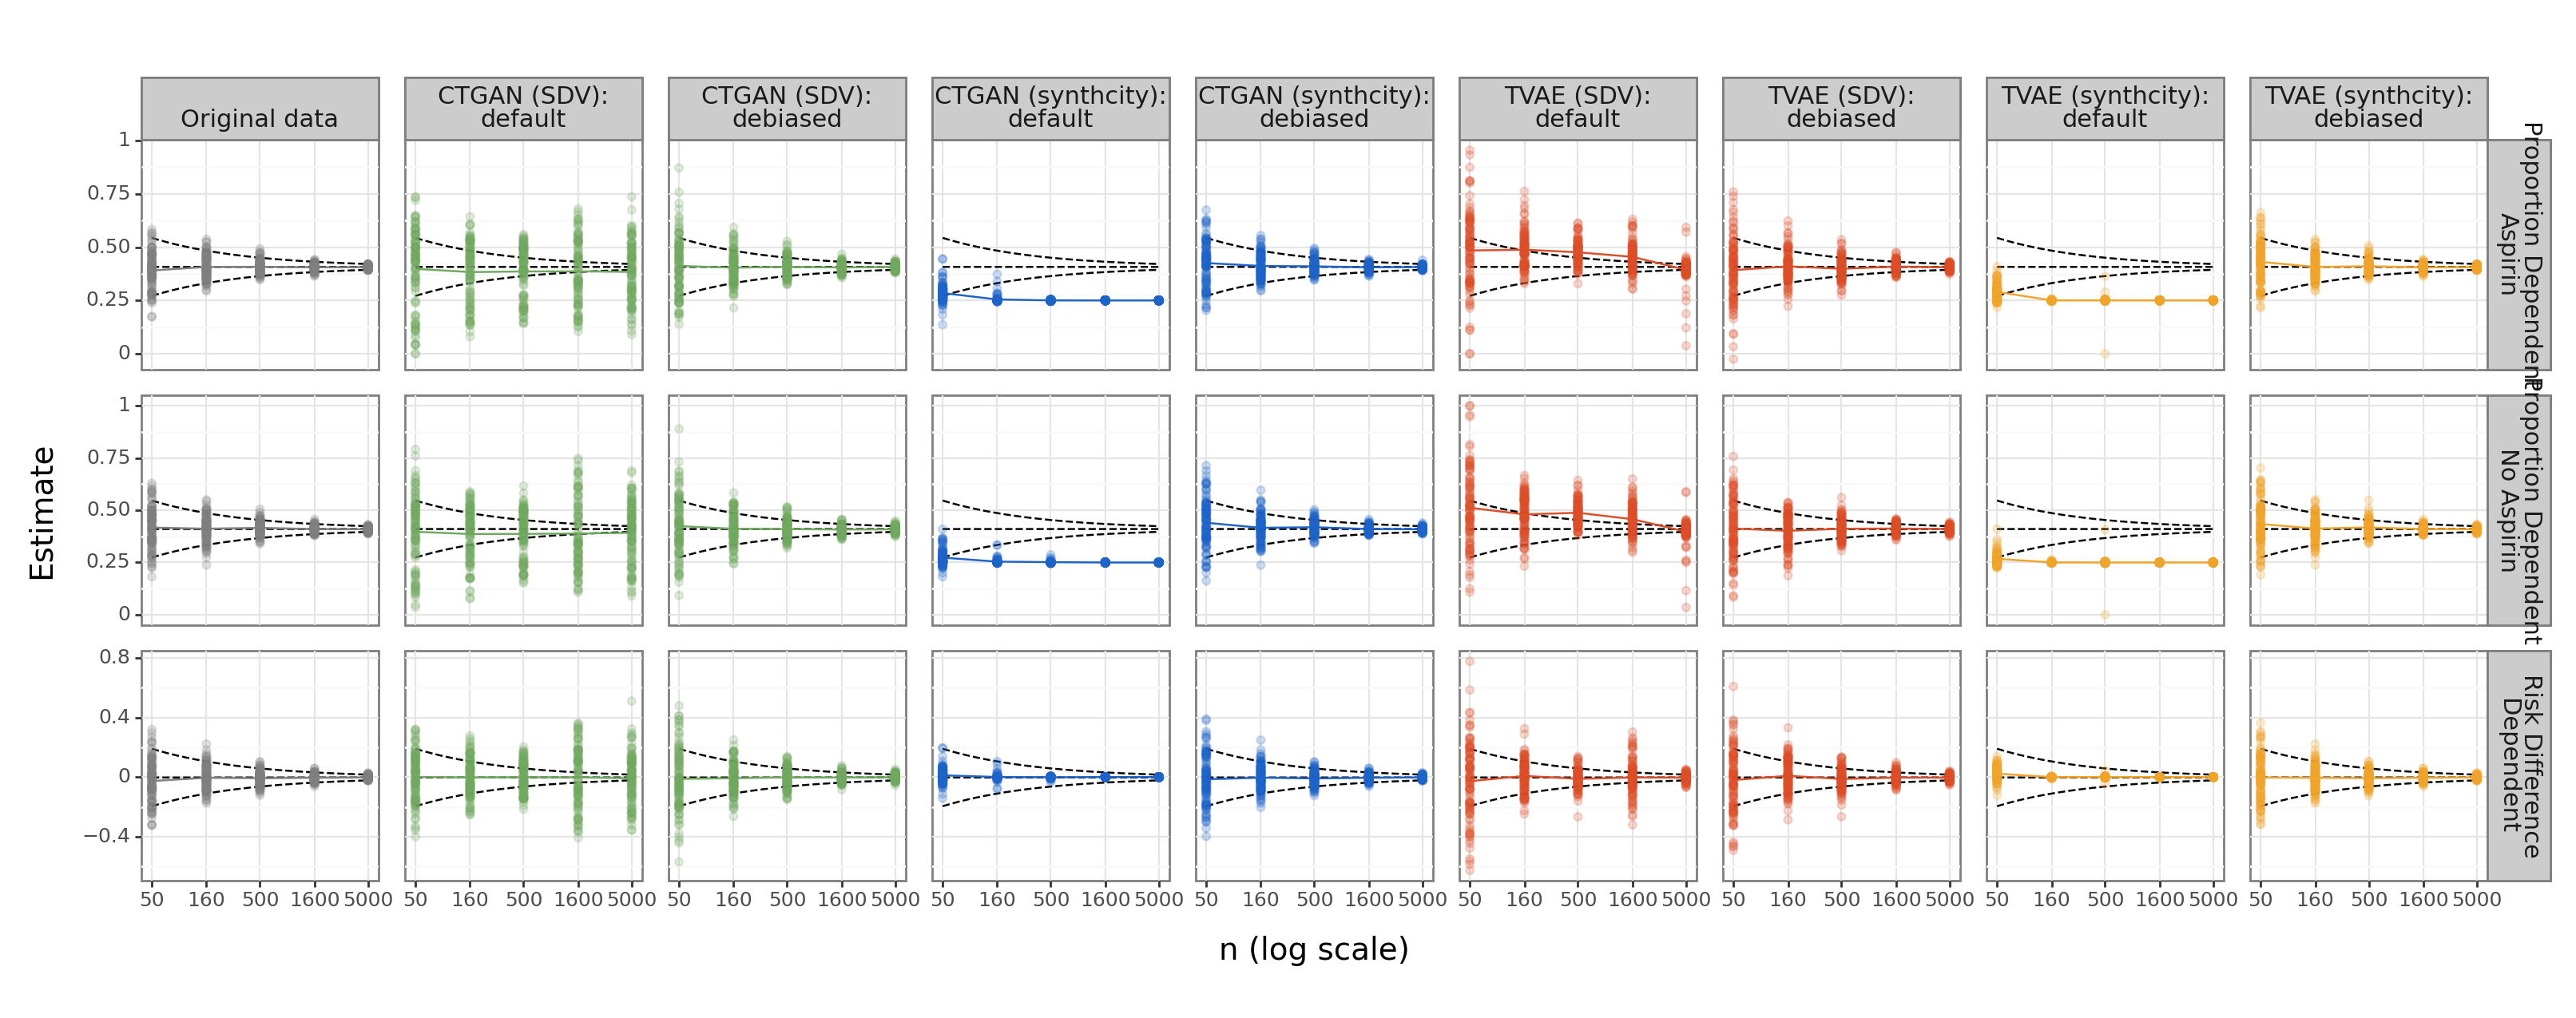

In [22]:
new_labels = {'Original_data': '\nOriginal data',
              'custom_ctgan_untargeted': 'CTGAN (SDV):\ndefault', 'ctgan_untargeted': 'CTGAN (synthcity):\ndefault',
              'custom_tvae_untargeted':'TVAE (SDV):\ndefault', 'tvae_untargeted':'TVAE (synthcity):\ndefault',
              'custom_ctgan_targeted': 'CTGAN (SDV):\ndebiased', 'ctgan_targeted': 'CTGAN (synthcity):\ndebiased',
              'custom_tvae_targeted':'TVAE (SDV):\ndebiased', 'tvae_targeted':'TVAE (synthcity):\ndebiased',
             'Prop_Aspirin_Dependent':'Proportion Dependent\nAspirin',
             'Prop_No_Aspirin_Dependent':'Proportion Dependent\nNo Aspirin',
             'Risk_Difference_Dependent':'Risk Difference\nDependent'}  

plot_IST_estimates = plot_bias(data['meta_data'], 
                               select_estimators=['Prop_Aspirin_Dependent', 'Prop_No_Aspirin_Dependent', 'Risk_Difference_Dependent'], 
                               name_original=['Original_data'],
                               list_generators=[ 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                               plot_outliers=True,
                               unit_rescale=unit_rescale,
                               plot_estimates=True,
                               ground_truth=ground_truth,
                               labels_plot = new_labels)
print(plot_IST_estimates)

### Convergence rate

Note that for ctgan_untargeted (synthcity) it was again not possible to calculate the convergence rate.

In [23]:
select_estimators=['Prop_Aspirin_Dependent']
table_convergence_rate(meta_data, select_estimators, unit_rescale, show_ci=True)

/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log


,generator,estimator,convergence rate
0,Original_data,Prop_Aspirin_Dependent,0.54 [0.47; 0.62]
1,ctgan_targeted,Prop_Aspirin_Dependent,0.57 [0.53; 0.60]
2,ctgan_untargeted,Prop_Aspirin_Dependent,inf [nan; nan]
3,custom_ctgan_targeted,Prop_Aspirin_Dependent,0.52 [0.45; 0.59]
4,custom_ctgan_untargeted,Prop_Aspirin_Dependent,0.05 [-0.07; 0.17]
5,custom_tvae_targeted,Prop_Aspirin_Dependent,0.54 [0.46; 0.61]
6,custom_tvae_untargeted,Prop_Aspirin_Dependent,0.21 [-0.05; 0.47]
7,tvae_targeted,Prop_Aspirin_Dependent,0.57 [0.51; 0.63]
8,tvae_untargeted,Prop_Aspirin_Dependent,inf [nan; nan]


In [24]:
select_estimators=['Prop_No_Aspirin_Dependent']
table_convergence_rate(meta_data, select_estimators, unit_rescale, show_ci=True)

/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log


,generator,estimator,convergence rate
0,Original_data,Prop_No_Aspirin_Dependent,0.53 [0.47; 0.58]
1,ctgan_targeted,Prop_No_Aspirin_Dependent,0.55 [0.49; 0.61]
2,ctgan_untargeted,Prop_No_Aspirin_Dependent,inf [nan; nan]
3,custom_ctgan_targeted,Prop_No_Aspirin_Dependent,0.52 [0.45; 0.59]
4,custom_ctgan_untargeted,Prop_No_Aspirin_Dependent,0.01 [-0.14; 0.16]
5,custom_tvae_targeted,Prop_No_Aspirin_Dependent,0.52 [0.47; 0.58]
6,custom_tvae_untargeted,Prop_No_Aspirin_Dependent,0.21 [-0.04; 0.46]
7,tvae_targeted,Prop_No_Aspirin_Dependent,0.55 [0.48; 0.61]
8,tvae_untargeted,Prop_No_Aspirin_Dependent,inf [nan; nan]


In [25]:
select_estimators=['Risk_Difference_Dependent']
table_convergence_rate(meta_data, select_estimators, unit_rescale, show_ci=True)

/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log


,generator,estimator,convergence rate
0,Original_data,Risk_Difference_Dependent,0.56 [0.50; 0.61]
1,ctgan_targeted,Risk_Difference_Dependent,0.59 [0.56; 0.61]
2,ctgan_untargeted,Risk_Difference_Dependent,inf [nan; nan]
3,custom_ctgan_targeted,Risk_Difference_Dependent,0.53 [0.45; 0.61]
4,custom_ctgan_untargeted,Risk_Difference_Dependent,-0.04 [-0.27; 0.18]
5,custom_tvae_targeted,Risk_Difference_Dependent,0.53 [0.47; 0.58]
6,custom_tvae_untargeted,Risk_Difference_Dependent,0.41 [-0.02; 0.83]
7,tvae_targeted,Risk_Difference_Dependent,0.57 [0.52; 0.62]
8,tvae_untargeted,Risk_Difference_Dependent,inf [nan; nan]


### Additional to show why NaN values for untargated synthcity generator ('ctgan_untargeted', 'tvae_untargeted')

In [26]:
select_estimators=['Prop_Aspirin_Dependent']
table_convergence_rate_additional(meta_data, select_estimators, unit_rescale, show_ci=True) # but now only for generators: ['ctgan_untargeted', 'tvae_untargeted']

      n      bias
0    50  0.043044
1   160  0.017052
2   500  0.001993
3  1600  0.000000
4  5000  0.000000
      n      bias
0    50  0.037496
1   160  0.001160
2   500  0.027944
3  1600  0.000000
4  5000  0.000000


/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log


,generator,estimator,convergence rate
0,ctgan_untargeted,Prop_Aspirin_Dependent,inf [nan; nan]
1,tvae_untargeted,Prop_Aspirin_Dependent,inf [nan; nan]


Based on this output, one can see that there is no variability in the estimates for sample size n=1600 and n=5000, explaining why a convergence rate based on OLS could not be estimated.

### Coverage and type 1 error rate

In [27]:
# Remember
        # calculate true proportions
        # in aspirin group
        # IST_gt_asp = IST_gt[IST_gt['RXASP'] == 'Aspirin']
        # gt_prop_aspirin = IST_gt_asp[['OCCODE_dummy_1', 'OCCODE_dummy_2']].mean()
        # in no aspirin group
        # IST_gt_no_asp = IST_gt[IST_gt['RXASP'] == 'No aspirin']
        # gt_prop_no_aspirin = IST_gt_no_asp[['OCCODE_dummy_1', 'OCCODE_dummy_2']].mean()
        # calculate risk differences
        # IST_gt_Risk_Differences = gt_prop_aspirin - gt_prop_no_aspirin

ground_truth = {'Prop_Aspirin_Death': gt_prop_aspirin[0],
                'Prop_No_Aspirin_Death': gt_prop_no_aspirin[0],
                'Prop_Aspirin_Dependent': gt_prop_aspirin[1],
                'Prop_No_Aspirin_Dependent': gt_prop_no_aspirin[1],
                'Risk_Difference_Death': IST_gt_Risk_Differences[0],
               'Risk_Difference_Dependent': IST_gt_Risk_Differences[1]}
print(ground_truth)

{'Prop_Aspirin_Death': 0.2150638032990974, 'Prop_No_Aspirin_Death': 0.22475637569977192, 'Prop_Aspirin_Dependent': 0.4074074074074074, 'Prop_No_Aspirin_Dependent': 0.41022185361808006, 'Risk_Difference_Death': -0.009692572400674504, 'Risk_Difference_Dependent': -0.002814446210672672}


#### Coverage of proportion of dependent

In [28]:
#### Needed parameters
##
# Calculate the upper and lower bounds of the confidence interval
q = ss.norm.ppf(0.975)
upper_bound = meta_data['Prop_Aspirin_Dependent'] + q * np.sqrt(meta_data['Var_Prop_Aspirin_Dependent'])
lower_bound = meta_data['Prop_Aspirin_Dependent'] - q * np.sqrt(meta_data['Var_Prop_Aspirin_Dependent'])

# Check if the ground truth falls within the confidence interval for each row
meta_data['Prop_Aspirin_Coverage_Dependent'] = (
    (lower_bound <= ground_truth['Prop_Aspirin_Dependent']) &
    (ground_truth['Prop_Aspirin_Dependent'] <= upper_bound)
)

# Convert boolean values to True/False
meta_data['Prop_Aspirin_Coverage_Dependent'] = meta_data['Prop_Aspirin_Coverage_Dependent'].astype(bool)
meta_data['Prop_Aspirin_type1_Dependent'] = ~meta_data['Prop_Aspirin_Coverage_Dependent']
meta_data['Prop_Aspirin_type1_Dependent'] = meta_data['Prop_Aspirin_type1_Dependent'].astype(bool)

##
# Calculate the upper and lower bounds of the confidence interval with correction factor
upper_bound = meta_data['Prop_Aspirin_Dependent'] + q * np.sqrt(meta_data['Var_Prop_Aspirin_Dependent']) * np.sqrt(2)
lower_bound = meta_data['Prop_Aspirin_Dependent'] - q * np.sqrt(meta_data['Var_Prop_Aspirin_Dependent']) * np.sqrt(2)

# Check if the ground truth falls within the confidence interval for each row
meta_data['Prop_Aspirin_Coverage_corrected_Dependent'] = (
    (lower_bound <= ground_truth['Prop_Aspirin_Dependent']) &
    (ground_truth['Prop_Aspirin_Dependent'] <= upper_bound)
)

# Convert boolean values to True/False
meta_data['Prop_Aspirin_Coverage_corrected_Dependent'] = meta_data['Prop_Aspirin_Coverage_corrected_Dependent'].astype(bool)
meta_data['Prop_Aspirin_type1_corrected_Dependent'] = ~meta_data['Prop_Aspirin_Coverage_corrected_Dependent']
meta_data['Prop_Aspirin_type1_corrected_Dependent'] = meta_data['Prop_Aspirin_type1_corrected_Dependent'].astype(bool)


##
# Important: the correction factor should not be used when looking at original data!
# So adapt the output manually to ensure this.
# Convert boolean values to True/False
meta_data.loc['Original_data', 'Prop_Aspirin_Coverage_corrected_Dependent'] = meta_data.loc['Original_data','Prop_Aspirin_Coverage_Dependent']
meta_data.loc['Original_data', 'Prop_Aspirin_type1_corrected_Dependent'] = ~meta_data.loc['Original_data','Prop_Aspirin_Coverage_Dependent']
meta_data.loc['Original_data','Prop_Aspirin_type1_corrected_Dependent'] = meta_data.loc['Original_data','Prop_Aspirin_type1_corrected_Dependent']


/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
/apps/gent/RHEL8/cascadelake-ib/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt


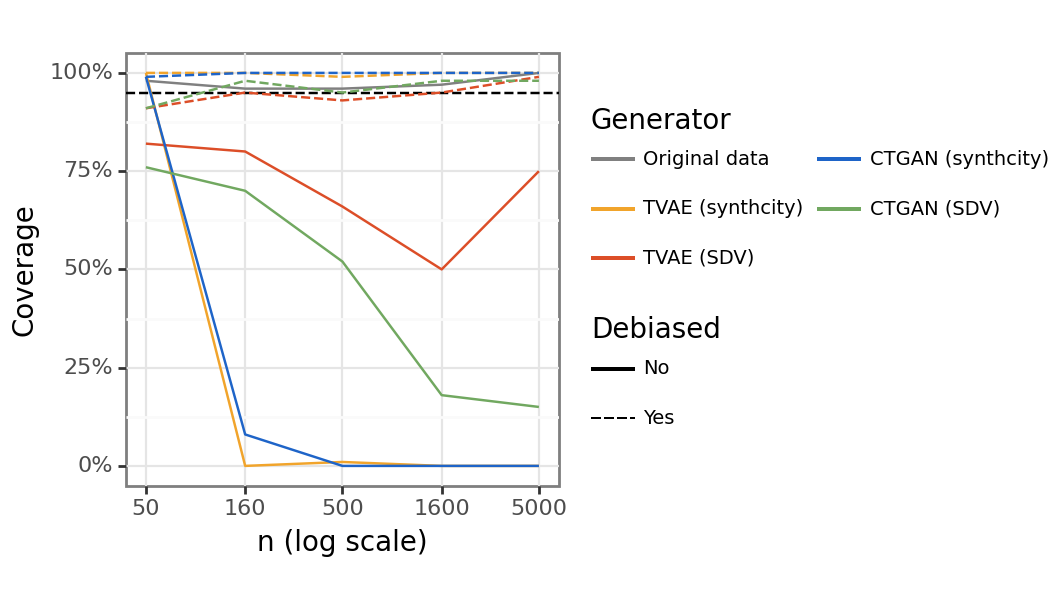

<Figure Size: (530 x 300)>

In [29]:
# Select estimators
new_labels = {'Original_data': 'Original data', 
              'custom_ctgan': 'CTGAN (SDV)', 'ctgan': 'CTGAN (synthcity)',
              'custom_tvae':'TVAE (SDV)', 'tvae':'TVAE (synthcity)'}    

select_estimators = ['Prop_Aspirin_Coverage_Dependent', 'Prop_Aspirin_Coverage_corrected_Dependent']
Coverage_dependent_aspirin_paper = plot_coverage_paper(meta_data, select_estimators,
                                                       name_original=['Original_data'],
                                                       list_generators=['tvae', 'custom_tvae', 'ctgan', 'custom_ctgan'],
                                                       labels_plot=new_labels,
                                                       figure_size=(5.3,3))
Coverage_dependent_aspirin_paper

#### Type 1 error rate for risk difference

In [30]:
# First make needed variables to be able to calculate the type 1 error rate for the risk difference in outcome "dependent" 
data['meta_data']['n'] = pd.to_numeric(data['meta_data']['n'], errors='coerce')
data['meta_data']['Prop_Aspirin_Dependent'] = pd.to_numeric(data['meta_data']['Prop_Aspirin_Dependent'], errors='coerce')
data['meta_data']['Prop_No_Aspirin_Dependent'] = pd.to_numeric(data['meta_data']['Prop_No_Aspirin_Dependent'], errors='coerce')
data['meta_data']['Var_Prop_Aspirin_Dependent'] = pd.to_numeric(data['meta_data']['Var_Prop_Aspirin_Dependent'], errors='coerce')
data['meta_data']['Var_Prop_No_Aspirin_Dependent'] = pd.to_numeric(data['meta_data']['Var_Prop_No_Aspirin_Dependent'], errors='coerce')

data['meta_data']['Risk_Difference_Dependent'] = data['meta_data']['Prop_Aspirin_Dependent'] - data['meta_data']['Prop_No_Aspirin_Dependent']
data['meta_data']['SE_Risk_Difference_Dependent'] = np.sqrt(data['meta_data']['Var_Prop_Aspirin_Dependent'] + data['meta_data']['Var_Prop_No_Aspirin_Dependent'])
data['meta_data']['SE_Risk_Difference_corrected_Dependent'] = np.sqrt(data['meta_data']['Var_Prop_Aspirin_Dependent'] + data['meta_data']['Var_Prop_No_Aspirin_Dependent'])*np.sqrt(2)
data['meta_data'].loc['Original_data', 'SE_Risk_Difference_corrected_Dependent'] = data['meta_data'].loc['Original_data', 'SE_Risk_Difference_Dependent']
# Here I make sure that there is no Raab correction factor applied on the original dataset

In [31]:
#### Calculate coverage and type 1 error rate for the risk difference in outcome "death" 
##
# Calculate the upper and lower bounds of the confidence interval
q = ss.norm.ppf(0.975)
upper_bound = meta_data['Risk_Difference_Dependent'] + q * meta_data['SE_Risk_Difference_Dependent']
lower_bound = meta_data['Risk_Difference_Dependent'] - q * meta_data['SE_Risk_Difference_Dependent']

# Check if the ground truth falls within the confidence interval for each row
meta_data['Risk_Difference_Coverage_Dependent'] = (
    (lower_bound <= ground_truth['Risk_Difference_Dependent']) &
    (ground_truth['Risk_Difference_Dependent'] <= upper_bound)
)

# Convert boolean values to True/False
meta_data['Risk_Difference_Coverage_Dependent'] = meta_data['Risk_Difference_Coverage_Dependent'].astype(bool)
# meta_data['Risk_Difference_TypeI'] = not meta_data['Risk_Difference_Coverage'].astype(bool)
meta_data['Risk_Difference_type1_Dependent'] = ~meta_data['Risk_Difference_Coverage_Dependent']
# Convert boolean values to True/False
meta_data['Risk_Difference_type1_Dependent'] = meta_data['Risk_Difference_type1_Dependent'].astype(bool)

##
# With correction factor
upper_bound = meta_data['Risk_Difference_Dependent'] + q * meta_data['SE_Risk_Difference_corrected_Dependent']
lower_bound = meta_data['Risk_Difference_Dependent'] - q * meta_data['SE_Risk_Difference_corrected_Dependent']

# Check if the ground truth falls within the confidence interval for each row
meta_data['Risk_Difference_Coverage_corrected_Dependent'] = (
    (lower_bound <= ground_truth['Risk_Difference_Dependent']) &
    (ground_truth['Risk_Difference_Dependent'] <= upper_bound)
)

# Convert boolean values to True/False
meta_data['Risk_Difference_Coverage_corrected_Dependent'] = meta_data['Risk_Difference_Coverage_corrected_Dependent'].astype(bool)
# meta_data['Risk_Difference_TypeI'] = not meta_data['Risk_Difference_Coverage'].astype(bool)
meta_data['Risk_Difference_type1_corrected_Dependent'] = ~meta_data['Risk_Difference_Coverage_corrected_Dependent']
# Convert boolean values to True/False
meta_data['Risk_Difference_type1_corrected_Dependent'] = meta_data['Risk_Difference_type1_corrected_Dependent'].astype(bool)


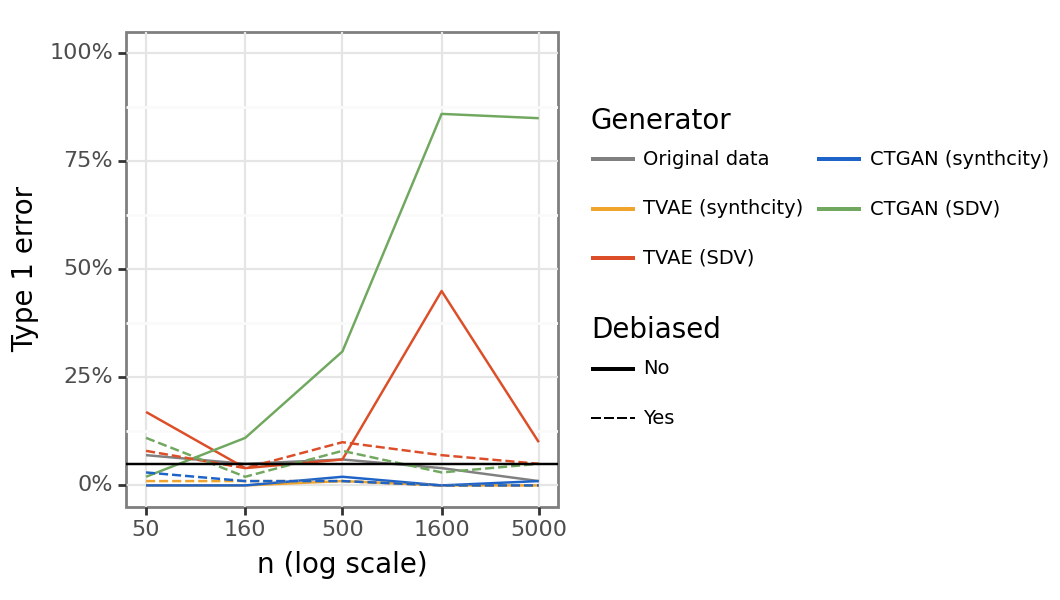

<Figure Size: (530 x 300)>

In [32]:
new_labels = {'Original_data': 'Original data', 
              'custom_ctgan': 'CTGAN (SDV)', 'ctgan': 'CTGAN (synthcity)',
              'custom_tvae':'TVAE (SDV)', 'tvae':'TVAE (synthcity)'}    
select_estimators = ['Risk_Difference_type1_Dependent', 'Risk_Difference_type1_corrected_Dependent']
RD_Type1 = plot_type_I_paper(meta_data, select_estimators, 
                             name_original=['Original_data'],
                             list_generators=['tvae', 'custom_tvae', 'ctgan', 'custom_ctgan'],
                             labels_plot=new_labels,
                            figure_size=(5.3,3))
RD_Type1

#### 15 CIs

In [33]:
ground_truth = {'Prop_Aspirin_Death': gt_prop_aspirin[0],
                'Prop_No_Aspirin_Death': gt_prop_no_aspirin[0],
                'Prop_Aspirin_Dependent': gt_prop_aspirin[1],
                'Prop_No_Aspirin_Dependent': gt_prop_no_aspirin[1],
                'Risk_Difference_Death': IST_gt_Risk_Differences[0],
               'Risk_Difference_Dependent': IST_gt_Risk_Differences[1]}
print(ground_truth)
meta_data = data['meta_data']
meta_data_subset = meta_data[meta_data['n'] == 500]
meta_data_subset = meta_data_subset[meta_data_subset['generator'].isin(['Original_data', 'custom_ctgan_untargeted', 'custom_ctgan_targeted'])]
meta_data_subset

{'Prop_Aspirin_Death': 0.2150638032990974, 'Prop_No_Aspirin_Death': 0.22475637569977192, 'Prop_Aspirin_Dependent': 0.4074074074074074, 'Prop_No_Aspirin_Dependent': 0.41022185361808006, 'Risk_Difference_Death': -0.009692572400674504, 'Risk_Difference_Dependent': -0.002814446210672672}


,run,n,generator,Prop_Aspirin_Death,Prop_No_Aspirin_Death,Var_Prop_Aspirin_Death,Var_Prop_No_Aspirin_Death,Prop_Aspirin_Dependent,Prop_No_Aspirin_Dependent,Var_Prop_Aspirin_Dependent,...,Risk_Difference_Coverage_corrected_Death,Risk_Difference_type1_corrected_Death,Prop_Aspirin_Coverage_Dependent,Prop_Aspirin_type1_Dependent,Prop_Aspirin_Coverage_corrected_Dependent,Prop_Aspirin_type1_corrected_Dependent,Risk_Difference_Coverage_Dependent,Risk_Difference_type1_Dependent,Risk_Difference_Coverage_corrected_Dependent,Risk_Difference_type1_corrected_Dependent
Original_data,run_1,500,Original_data,0.195021,0.250965,0.000651,0.000726,0.468880,0.389961,0.001033,...,True,False,True,False,True,False,True,False,True,False
custom_ctgan_untargeted,run_1,500,custom_ctgan_untargeted,0.092511,0.128205,0.000370,0.000409,0.502203,0.380952,0.001101,...,True,False,False,True,False,True,False,True,False,True
custom_ctgan_targeted,run_1,500,custom_ctgan_targeted,0.164389,0.244025,0.000605,0.000676,0.469039,0.386913,0.001097,...,True,False,True,False,True,False,True,False,True,False
Original_data,run_2,500,Original_data,0.195489,0.209402,0.000591,0.000707,0.492481,0.393162,0.000940,...,True,False,False,True,False,True,False,True,False,True
custom_ctgan_untargeted,run_2,500,custom_ctgan_untargeted,0.098039,0.138776,0.000347,0.000488,0.474510,0.497959,0.000978,...,True,False,False,True,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
custom_ctgan_untargeted,run_99,500,custom_ctgan_untargeted,0.273859,0.409266,0.000825,0.000933,0.543568,0.413127,0.001029,...,False,True,False,True,False,True,False,True,False,True
custom_ctgan_targeted,run_99,500,custom_ctgan_targeted,0.191353,0.239835,0.000642,0.000704,0.482561,0.451741,0.001036,...,True,False,False,True,True,False,True,False,True,False
Original_data,run_100,500,Original_data,0.225000,0.259091,0.000623,0.000873,0.392857,0.490909,0.000852,...,True,False,True,False,True,False,False,True,False,True
custom_ctgan_untargeted,run_100,500,custom_ctgan_untargeted,0.082192,0.177885,0.000258,0.000703,0.455479,0.370192,0.000849,...,False,True,True,False,True,False,False,True,True,False


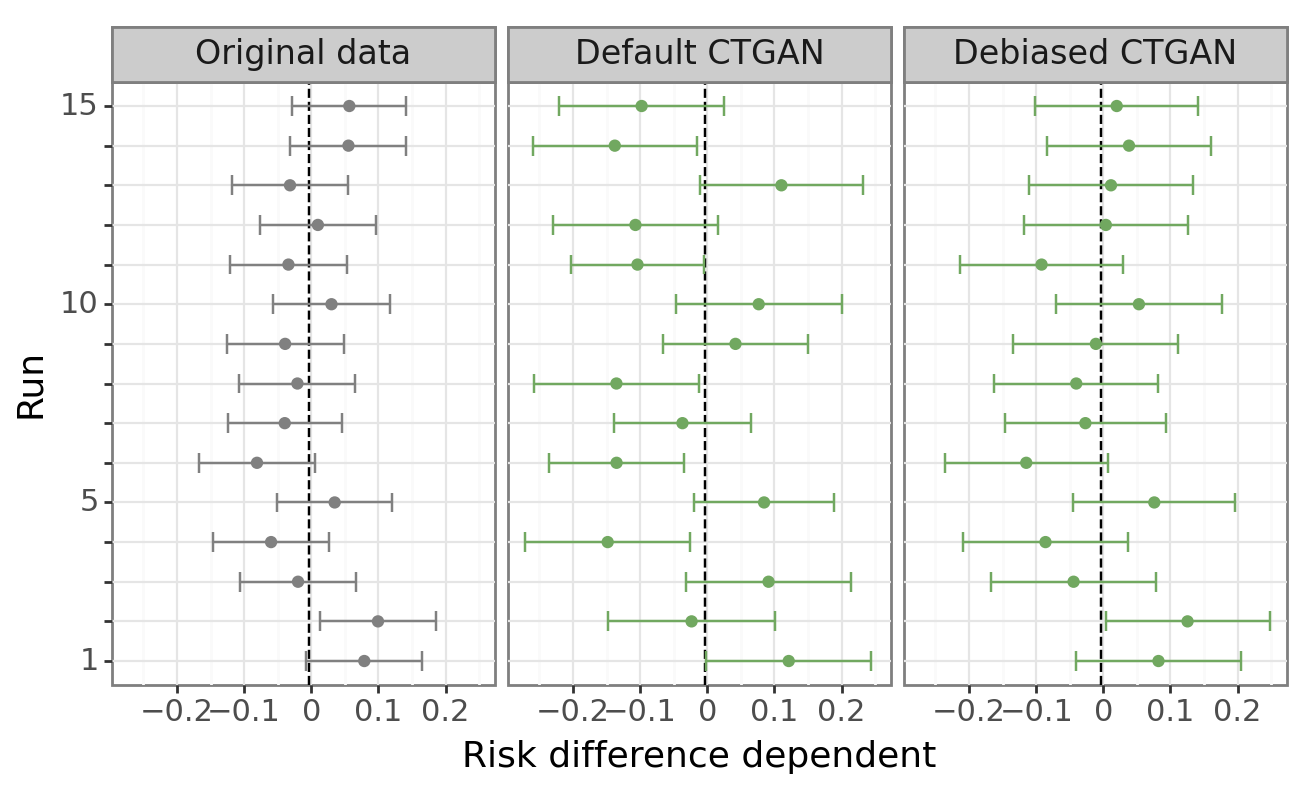

<Figure Size: (650 x 400)>

In [34]:
### Make figure that compares the first 15 confidence intervals
# Presets
n_runs = 15 # plot first 15 runs
select_estimator = 'Risk_Difference_Dependent' 
select_estimator_ylab = 'Risk difference dependent'
q = ss.norm.ppf(0.975)

# Reformating 
plot_data = meta_data_subset.head(n=n_runs*3).copy() # select first n_runs

plot_data['run'] =  pd.Categorical(list(map(lambda x: str(int(x[len('run_'):])), plot_data['run'])), # change label 
                                   categories=[str(i) for i in range(n_runs+1)]) # reorder categories

# Add correction factor
plot_data = pd.concat([plot_data.assign(correction_factor = 1, formula_SE='Naive SE'),
                       plot_data.assign(correction_factor = np.sqrt(2), formula_SE='Model-based SE')], axis=0)
plot_data['formula_SE'] =  pd.Categorical(plot_data['formula_SE'], categories=['Naive SE', 'Model-based SE']) # reorder categories

# Calculate confidence intervals
plot_data[select_estimator + '_ll'] = plot_data.apply(lambda i: i[select_estimator] - i['correction_factor']*q*i['SE_Risk_Difference_Dependent'], axis=1) # lower limit of CI
plot_data[select_estimator + '_ul'] = plot_data.apply(lambda i: i[select_estimator] + i['correction_factor']*q*i['SE_Risk_Difference_Dependent'], axis=1) # upper limit of CI

# Relabel
relabel_generators = {'Original_data': 'Original data', 
                      'custom_ctgan_untargeted': 'Default CTGAN',
                      'custom_ctgan_targeted': 'Debiased CTGAN'}
# Reorder levels of 'generator' variable
plot_data['generator'] = pd.Categorical(plot_data['generator'], categories=[ 'Original_data', 'custom_ctgan_untargeted', 'custom_ctgan_targeted'])

# I only want to display the confidence intervals with correction factor Raab. 
# However, this should not be applied on original data, so therefore
# I first take the confidence intervals of the uncorrected and copy paste them in corrected confidence intervals for original data
plot_data.loc[(plot_data['formula_SE'] == 'Model-based SE') & (plot_data.index == 'Original_data'), select_estimator + '_ll'] = plot_data.loc[(plot_data['formula_SE'] == 'Naive SE') & (plot_data.index == 'Original_data'), select_estimator + '_ll']
plot_data.loc[(plot_data['formula_SE'] == 'Model-based SE') & (plot_data.index == 'Original_data'), select_estimator + '_ul'] = plot_data.loc[(plot_data['formula_SE'] == 'Naive SE') & (plot_data.index == 'Original_data'), select_estimator + '_ul']
plot_data_Raab = plot_data[plot_data['formula_SE'] == 'Model-based SE']

# Add ground truth to each facet
intercepts = pd.DataFrame({'generator': plot_data['generator'].unique(),
                           'estimator': [select_estimator]*len(plot_data['generator'].unique()),
                           'intercept': [ground_truth[select_estimator]]*len(plot_data['generator'].unique())})

plot_CI_corrected_PAPER = ggplot(plot_data_Raab.query('not (generator==\'original\' & formula_SE==\'Corrected SE\')'), 
                                 aes(y=select_estimator, x='run', colour='generator', group='formula_SE', alpha='formula_SE')) +\
    geom_hline(data=intercepts, mapping=aes(yintercept='intercept', linetype='generator'), colour='black') +\
    geom_point(position=position_dodge(0.75)) +\
    scale_colour_manual(values={'Original_data': '#808080', 'custom_ctgan_untargeted': '#71A860', 'custom_ctgan_targeted': '#71A860'}) +\
    scale_linetype_manual(values={'Original_data': 'dashed', 'custom_ctgan_untargeted': 'dashed', 'custom_ctgan_targeted': 'dashed'}, breaks=['original'], labels=['Population parameter']) +\
    scale_alpha_manual(values={'Naive SE': 1, 'Model-based SE': 1}) +\
    geom_errorbar(aes(ymin=select_estimator + '_ll', ymax=select_estimator + '_ul', group='formula_SE'), position = position_dodge(0.75)) +\
    facet_wrap('generator', labeller=labeller(cols=lambda x: relabel_generators[x])) +\
    labs(y=select_estimator_ylab, x='Run') +\
    guides(alpha=guide_legend(title='', reverse=True), 
           colour=False,
           linetype=guide_legend(title='')) +\
    scale_x_discrete(breaks=[str(i) for i in range(1, 16)], labels=['1','','','','5','','','','','10','','','','','15']) +\
    theme_bw() +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=13), # axis title size
          strip_text=element_text(size=12), # facet_grid title size
          axis_text=element_text(size=11), # axis labels size
          legend_position='none',
          legend_title=element_blank(),
          legend_text=element_text(size=10),
          figure_size=(6.5,4)) +\
    coord_flip()
plot_CI_corrected_PAPER
